In [795]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [796]:
import numpy as np
from Aggregation_alternative import Agregator
import matplotlib.pyplot as plt
from functools import partial

In [797]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [798]:
f1=lambda x:1-np.sum(np.pi*x,axis=-1)**2/2#+np.sum(np.pi*x,axis=-1)**4/24
f2=lambda x:np.cos(np.pi*np.sum(x,axis=-1))
def get_data(k,scale,seed=0):
    np.random.seed(seed)
    X=scale*(np.random.rand(k,1)-1.0/2)
    Y=np.where(np.sum(X,axis=-1)>0,f1(X),f2(X))
    return X,Y


In [799]:
scale=4
X,Y=get_data(30,scale,seed=56)

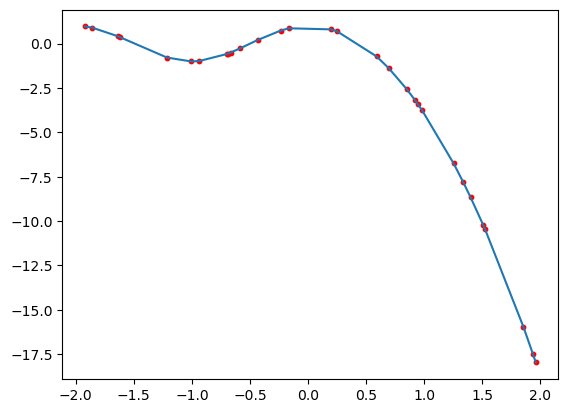

In [800]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted)
plt.scatter(np.sum(X,axis=-1),Y,s=10,c='r')

In [801]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

In [802]:
models=list(map(lambda x: x.fit(X,Y),models))
print(list(map(lambda x: x.score(X,Y),models)))

[0.6342118263394486, 1.0, 0.9981497054423479, 0.7147146970116662, 0.9592991054495763, 0.9999995054419785]


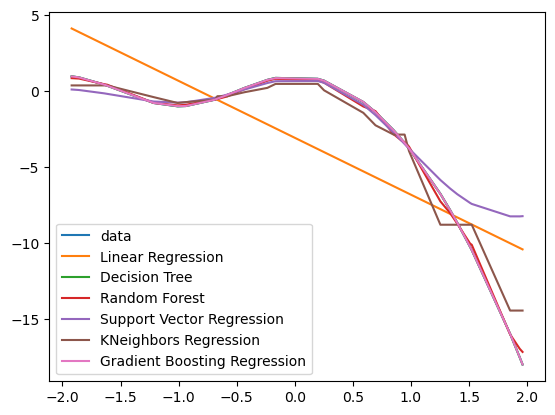

In [803]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted,label='data')
for model,model_name in zip(models,model_names):
    plt.plot(np.sum(X_sorted,axis=-1),model.predict(X_sorted),label=model_name)

plt.legend()

In [804]:
n_additional=10
X_additional,Y_additional=get_data(n_additional,scale,seed=5)
X_test,Y_test=np.concatenate([X_additional,X]),np.concatenate([Y_additional,Y])

In [833]:
def constant_kernel(x,y,mat):
    return np.tile(mat,(x.shape[0],y.shape[0],1,1))

def linear_separable_kernel(x,y,mat):
    K=x@y.T
    return K[:,:,None,None]*mat[None,None,:,:]

from sklearn.metrics.pairwise import rbf_kernel
def gaussian_separable_kernel(x,y,mat,l):
    K=rbf_kernel(x,y,gamma=1/l**2)+0.1
    return K[:,:,None,None]*mat[None,None,:,:]
    
ratio=0.2
constant_mat=(1-ratio)*np.eye(model_number)+ratio*np.ones((model_number,model_number))

model_values=np.stack(list(map(lambda x: x.predict(X_test),models)),axis=0)
constant_mat=(1-ratio)*np.eye(model_number)+ratio*np.corrcoef(model_values-Y_test[None,:])
print(constant_mat)

my_kernel=partial(gaussian_separable_kernel,mat=constant_mat,l=1)

[[1.         0.04065258 0.09156611 0.13259925 0.13127584 0.04095162]
 [0.04065258 1.         0.16237905 0.04110751 0.01250241 0.19998955]
 [0.09156611 0.16237905 1.         0.10589772 0.11137793 0.16270815]
 [0.13259925 0.04110751 0.10589772 1.         0.16008529 0.04138014]
 [0.13127584 0.01250241 0.11137793 0.16008529 1.         0.01295898]
 [0.04095162 0.19998955 0.16270815 0.04138014 0.01295898 1.        ]]


In [834]:
mean_intercept=np.ones(len(models))
mean_intercept=mean_intercept/np.sum(mean_intercept)

In [835]:
aggregate=Agregator(K=my_kernel,models=models,kernel_name='linear',intercept_choice='fit')

In [836]:
aggregate=aggregate.fit(X_test,Y_test,alpha=1)

In [837]:
aggregate.model_covariance=np.zeros((model_number,model_number))

In [838]:
aggregate.intercept

array([-0.01713192,  0.26487784,  0.26042166,  0.08066972,  0.20535778,
        0.26473527])

In [839]:
aggregate.coef_.shape

(40, 6)

In [840]:
np.linalg.norm(aggregate.coef_,axis=0)

array([0.34554326, 0.3738145 , 0.38916527, 0.27287745, 0.41422519,
       0.3737885 ])

In [841]:
n=1000
X_eval,Y_eval=get_data(n,scale,seed=2)

In [842]:

res=aggregate.predict(X_eval,return_alpha=True,return_cov=True)
pred_aggregate,alpha=res['pred_aggregate'],res['alpha']
cov,cov_alpha=res['covariance'],res['covariance_alpha']

In [843]:
idx=np.argsort(np.sum(X_eval,axis=-1))

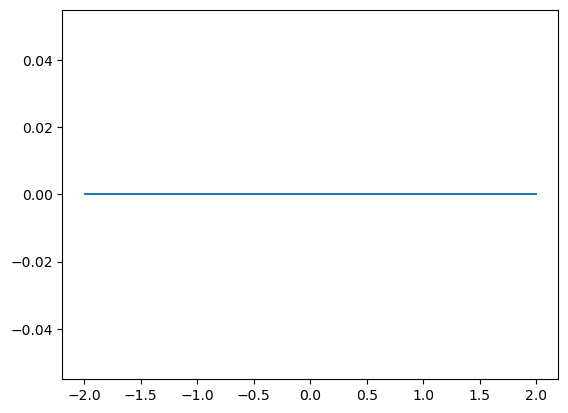

In [844]:
plt.plot(X_eval[idx,0],np.einsum("ijk,kj->i", cov_alpha, aggregate.model_covariance)[idx],label='aggregate')

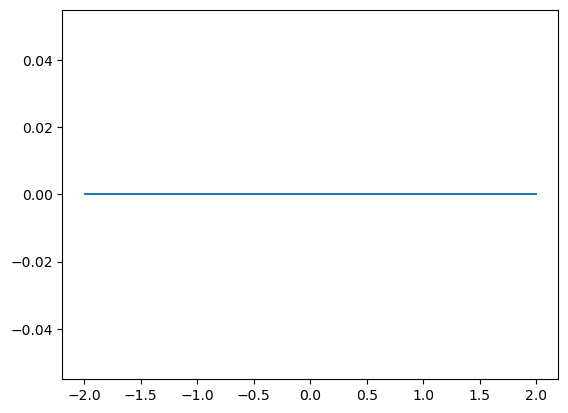

In [845]:

plt.plot(X_eval[idx,0],np.einsum("jk,ji,ki->i", aggregate.model_covariance, alpha, alpha)[idx],label='aggregate')

In [846]:
alpha.shape

(6, 1000)

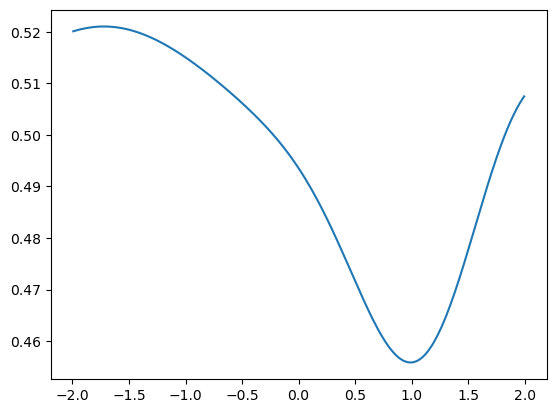

In [847]:
plt.plot(X_eval[idx,0],np.linalg.norm(alpha,axis=(0))[idx],label='aggregate')

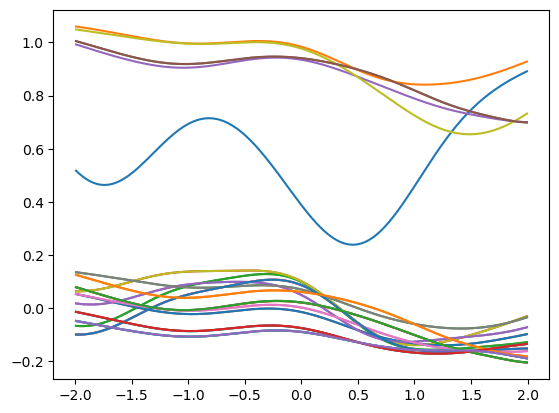

In [848]:
for i in range(6):
    for j in range(6):
        plt.plot(X_eval[idx,0],cov_alpha[idx,i,j],label='aggregate')


In [849]:
cov_alpha.shape

(1000, 6, 6)

In [850]:
cov.shape

(1000,)

<Figure size 640x480 with 0 Axes>

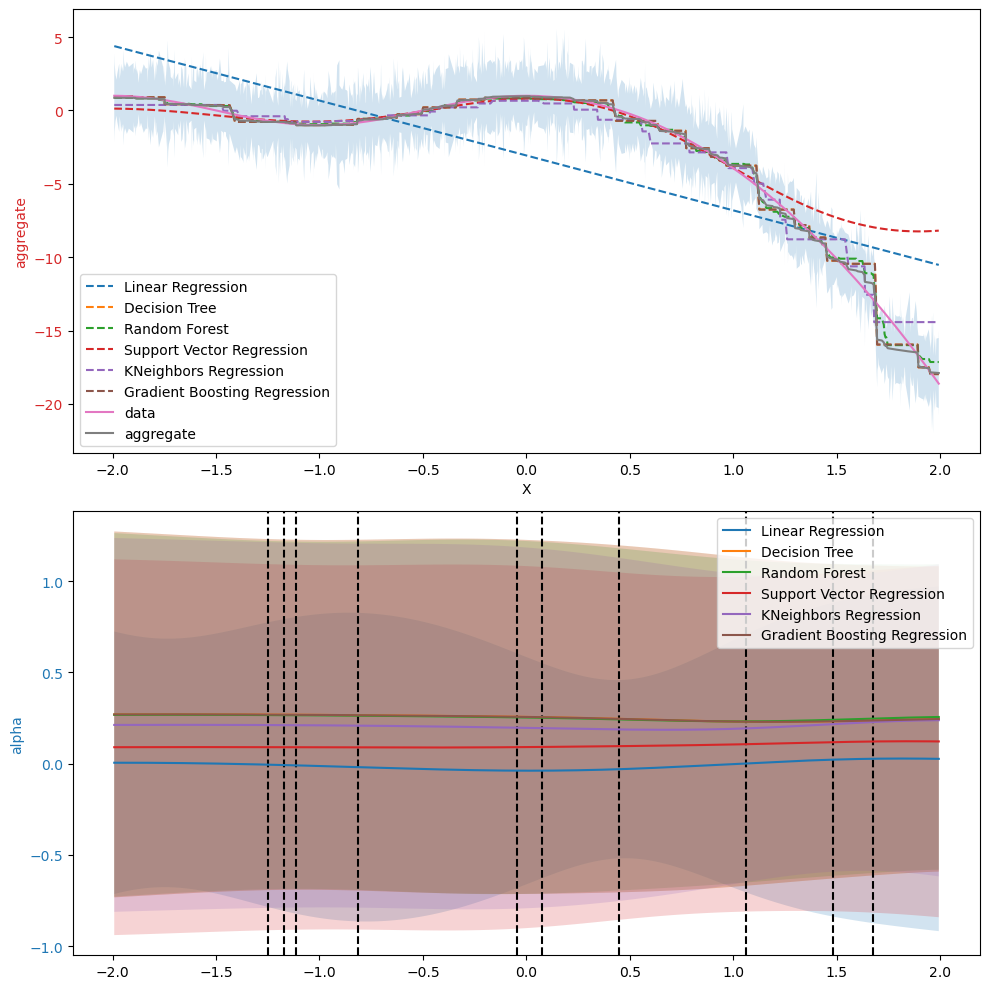

<Figure size 640x480 with 0 Axes>

In [851]:
#sort the data by X value
idx=np.argsort(np.sum(X_eval,axis=-1))
X_eval_sorted=X_eval[idx]
Y_eval_sorted=Y_eval[idx]
pred_aggregate_sorted=pred_aggregate[idx]
#two plot one on top of the other. first one is evolution of the aggregate, second evolution of alpha

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))

color = 'tab:red'
ax1.set_xlabel('X')
ax1.set_ylabel('aggregate', color=color)
ax1.tick_params(axis='y', labelcolor=color)
for model,model_name in zip(models,model_names):
    ax1.plot(np.sum(X_eval_sorted,axis=-1),model.predict(X_eval_sorted),label=model_name,linestyle='--')
ax1.plot(np.sum(X_eval_sorted,axis=-1),Y_eval_sorted,label='data')
ax1.plot(np.sum(X_eval_sorted,axis=-1),pred_aggregate_sorted,label='aggregate')
#use cov to plot the confidence interval    
ax1.fill_between(np.sum(X_eval_sorted,axis=-1), pred_aggregate_sorted-np.sqrt(cov), pred_aggregate_sorted+np.sqrt(cov),alpha=0.2)
ax1.legend()



#use cov_alpha to plot the confidence interval 
color = 'tab:blue'
ax2.set_ylabel('alpha', color=color)  # we already handled the x-label with ax1
for xi in X_additional:
    ax2.axvline(x=np.sum(xi),color='k',linestyle='--')
for i,model in enumerate(model_names):
    ax2.plot(np.sum(X_eval_sorted,axis=-1), alpha[i][idx], label=model)
    ax2.fill_between(np.sum(X_eval_sorted,axis=-1), alpha[i][idx]-np.sqrt(cov_alpha[idx,i,i]), alpha[i][idx]+np.sqrt(cov_alpha[idx,i,i]),alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.figure()

In [852]:
error_aggregate=np.linalg.norm(Y_eval-pred_aggregate)
error_models={name:np.linalg.norm(Y_eval-model.predict(X_eval)) for name,model in zip(model_names,models)}
error_models['aggregate']=error_aggregate
print('\n'.join(['{}:{}'.format(name,error) for name,error in error_models.items()]))

Linear Regression:103.82411656902167
Decision Tree:17.565885823394634
Random Forest:14.416157092748515
Support Vector Regression:75.15586156936305
KNeighbors Regression:24.316132761804884
Gradient Boosting Regression:17.571549984363003
aggregate:14.275788419193521


In [853]:
aggregate.model_covariance

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [854]:
res=aggregate.predict(np.random.rand(1,1),return_alpha=True,return_cov=True)
pred_aggregate,alpha=res['pred_aggregate'],res['alpha']
cov,cov_alpha=res['covariance'],res['covariance_alpha']

In [855]:
alpha

array([[-0.02285362],
       [ 0.24046272],
       [ 0.23798901],
       [ 0.0983819 ],
       [ 0.18580791],
       [ 0.24028051]])

In [856]:
pred_aggregate

array([-0.99655541])

In [857]:
cov

array([6.43046239])

In [858]:
cov_alpha

array([[[ 0.26283823, -0.09221129, -0.09606441, -0.09072039,
         -0.10623401, -0.09206719],
        [-0.09221129,  0.88233175, -0.04449689, -0.14164793,
         -0.13879414,  0.00230608],
        [-0.09606441, -0.04449689,  0.85084794, -0.09975411,
         -0.0815791 , -0.04426467],
        [-0.09072039, -0.14164793, -0.09975411,  0.87575967,
         -0.01852916, -0.14150424],
        [-0.10623401, -0.13879414, -0.0815791 , -0.01852916,
          0.8342337 , -0.13853526],
        [-0.09206719,  0.00230608, -0.04426467, -0.14150424,
         -0.13853526,  0.88229634]]])

In [859]:
print(aggregate.model_covariance@cov_alpha[0])
(aggregate.model_covariance@cov_alpha[0]).shape

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


(6, 6)

In [860]:
np.trace(aggregate.model_covariance@cov_alpha[0])

0.0